In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import scipy.stats as st
import statsmodels.api as sm
import numpy as np
import matplotlib.animation as animation

In [19]:
data = pd.read_csv(".\\data\\ropa.csv", index_col='Date', header=0)
data['returns'] = data.interpolate(type='linear').pct_change()
data.index = pd.to_datetime(data.index)

rtrs = list(data['returns'])
rtrs = rtrs[1:]
ts = range(len(rtrs))

fitted_dist = pd.read_csv('fitted_distributions_best.csv', index_col=0)
fitted_dist['params'] = [eval(i) for i in fitted_dist['params']]
fitted_dist['l'] = [len(i) for i in fitted_dist['params']]
fitted_dist.head(11)

,distributions,SSE,AIC,BIC,params,l
0,genhyperbolic,253.766426,-0.005131,-880.853538,"(1.8895152570008256, 0.9744888418191312, -0.17...",5
1,mielke,254.286030,-5.107306,-885.903359,"(113.66376381867467, 178.03637652198557, -1.95...",4
2,johnsonsu,254.489831,-12.242223,-885.264046,"(0.45292121416598957, 1.8073562476394767, 0.01...",4
3,nct,254.492364,-12.172199,-885.256102,"(6.080773005016582, -0.6998121355455837, 0.016...",4
4,burr,254.760149,-5.415069,-884.416863,"(316.6117715992358, 0.6500750316125852, -3.495...",4
5,genlogistic,255.191801,-7.938155,-889.748026,"(0.6656231286676977, 0.008975804919760192, 0.0...",3
6,norminvgauss,257.047729,-10.996048,-877.283323,"(1.9393724002701813, -0.4573517172724848, 0.00...",4
7,burr12,257.198275,17.744374,-876.816092,"(6123126.734354196, 1.4952441410926172, -90962...",4
8,crystalball,277.539911,3.561114,-816.074358,"(1.40707753466191, 19.495100631017365, 0.00268...",4
9,t,296.106276,9.318657,-771.083027,"(6.080803251126445, 0.0015888318874874476, 0.0...",3


In [20]:
dst = fitted_dist['distributions'][:11]

In [21]:
for i in range(11):
    d = getattr(st, dst[i])
    d = d(*fitted_dist['params'][i])
    
    VaR_95 = d.ppf(.95)
    print(VaR_95)


0.037227893313236865
0.03714783268827082
0.03702911606650497
0.03698506399689028
0.037128133193290225
0.037155765329228575
0.03722066162376561
0.037426763577968813
0.03781368218375417
0.04032197453594778
0.04044127510860562


In [22]:
def add_VaR(df, distr):

    dist_type = getattr(st, distr)

    VaR_95 =[]
    VaR_99 = []
    for p in df['params']:
        p = eval(p)
        d = dist_type(*p)
        VaR_95.append( d.ppf(.95) )
        VaR_99.append( d.ppf(.99) )
    
    df['VaR_95'] = VaR_95
    df['VaR_99'] = VaR_99




In [23]:
def plot_vars(df,distr,data=rtrs, show=True,  save=False, name=''):
    plt.figure(figsize=(8*2, 6))
    ts = range(len(data))
    plt.plot(ts, data)
    plt.axvline(499, color='k')
    ts1 = list(df['t_max'])[1:]
    v95 = list(df['VaR_95'])[1:]
    v99 = list(df['VaR_99'])[1:]
    plt.plot(ts1, v95, label=r'$VaR_{95}$')
    plt.plot(ts1, v99,label=r'$VaR_{99}$')
    plt.title('VaR  - {} distribution'.format(distr))
    plt.legend()
    if save:
        plt.savefig(name)
    if show:
        plt.show()


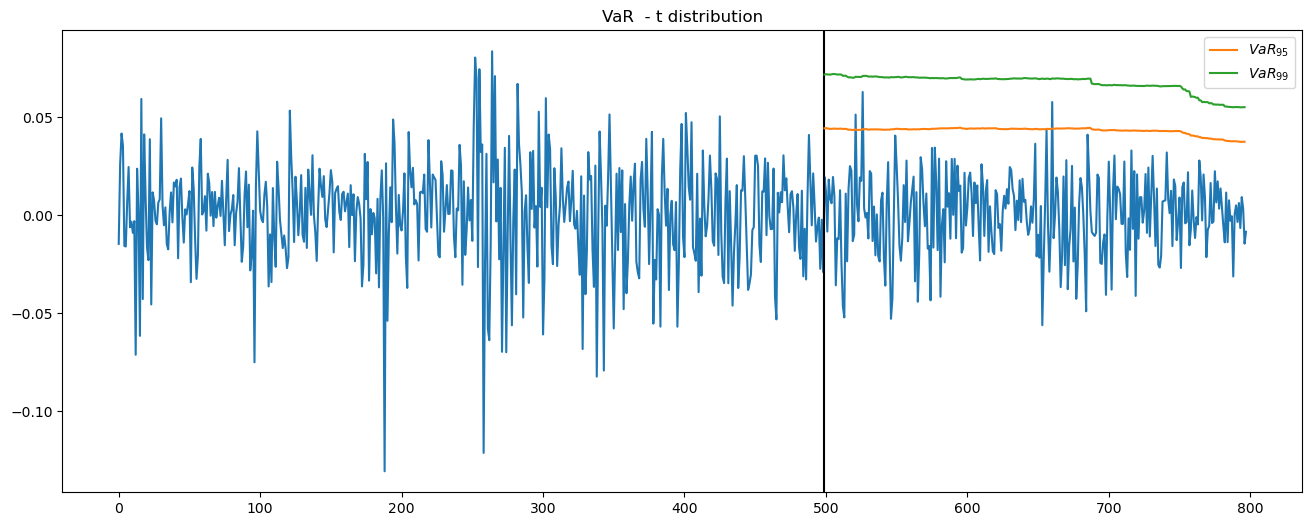

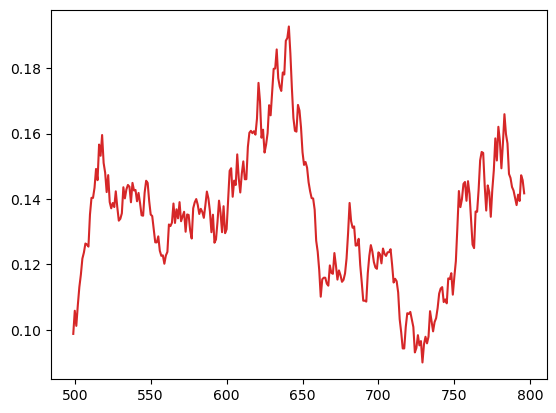

In [24]:
df1 = pd.read_csv('./data_distfit/fitted_t.csv', index_col=0)
add_VaR(df1, 't')
plot_vars(df1, 't')
plt.plot(df1['t_max'][1:], df1['SSE'][1:], color='C3')

In [77]:
def add_EVaR(df, distr):

    dist_type = getattr(st, distr)

    EVaR_95 =[]
    EVaR_99 = []
    for p in df['params']:
        p = eval(p)
        d = dist_type(*p)
        VaR_95=( d.ppf(.95) )
        VaR_99=( d.ppf(.99) )
        EVaR_95.append( d.expect(lb=VaR_95, conditional=True) )
        EVaR_99.append( d.expect(lb=VaR_99, conditional=True) )
    
    df['EVaR_95'] = EVaR_95
    df['EVaR_99'] = EVaR_99

In [78]:
add_EVaR(df1, 't')

In [79]:
df1

,t_min,t_max,params,SSE,ecdf_quantiles,VaR_95,VaR_99,EVaR_95,EVaR_99
-1,0,798,"(6.080803251126445, 0.0015888318874874476, 0.0...",0.131604,[-1.30628881e-01 -1.21261119e-01 -8.23572838e-...,0.040322,0.064102,0.055527,0.081647
0,0,499,"(5.360464598578685, 0.002028062353721335, 0.02...",0.098780,"[-0.1306288805140844, -0.12126111859385258, -0...",0.044278,0.071661,0.061933,0.092999
1,1,500,"(5.321771569906347, 0.0021115908063192882, 0.0...",0.105857,"[-0.1306288805140844, -0.12126111859385258, -0...",0.044344,0.071808,0.062061,0.093280
2,2,501,"(5.288460197098301, 0.002026474527667888, 0.02...",0.101235,"[-0.1306288805140844, -0.12126111859385258, -0...",0.044216,0.071732,0.061975,0.093308
3,3,502,"(5.241928798602011, 0.002006924283874679, 0.02...",0.107570,"[-0.1306288805140844, -0.12126111859385258, -0...",0.044091,0.071651,0.061890,0.093352
...,...,...,...,...,...,...,...,...,...
293,293,792,"(18.46934189425143, 0.00019678092206142114, 0....",0.141359,"[-0.08235728377794271, -0.07925833692240081, -...",0.037519,0.055073,0.048392,0.064980
294,294,793,"(17.770366010399627, 0.00012607907540755143, 0...",0.139425,"[-0.08235728377794271, -0.07925833692240081, -...",0.037363,0.054965,0.048271,0.064951
295,295,794,"(17.73884167806812, 0.0001625987601562807, 0.0...",0.147290,"[-0.08235728377794271, -0.07925833692240081, -...",0.037403,0.055011,0.048315,0.065002
296,296,795,"(17.731184434662175, 0.00015986835169561135, 0...",0.145779,"[-0.08235728377794271, -0.07925833692240081, -...",0.037399,0.055008,0.048312,0.065000
